In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft, ifft

In [2]:
def load_wav(name):
    fs, sig = wavfile.read(name)
    if len(sig.shape) > 1:
        sig = sig.mean(axis=1)
    return fs, sig

[0 0 0 ... 0 0 0]
(38550,)


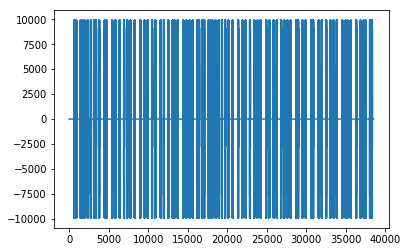

In [21]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('./sample.wav')
print(data[:])
plt.plot(data)
print(data.shape)

In [4]:
def fda(x, floor, ceil, fs):
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    return data

C:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


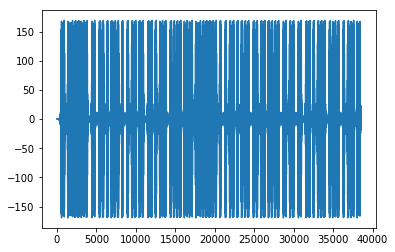

In [22]:
filted = fda(data[:], 17500, 18500, fs)
#plt.plot(data)
plt.plot(filted)

In [6]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

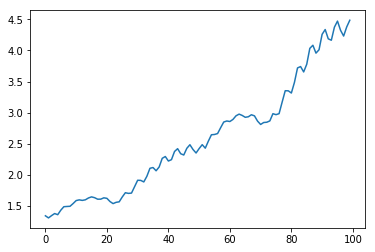

In [26]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[:100])

In [8]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

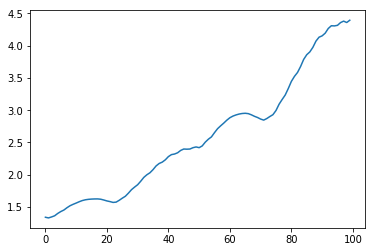

In [25]:
sm_data = smooth(impulse, 5)
#sm_data = smooth(data, 5)
plt.plot(sm_data[:100])

In [15]:
def find_max(data, half_window, thres=0.2):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > thres and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [27]:
impulse_pos = find_max(sm_data, 100)
print(impulse_pos)

[598, 852, 1398, 1648, 1902, 2302, 2698, 3098, 3352, 3752, 4448, 4702, 5398, 5802, 6352, 6898, 7298, 7702, 8248, 8952, 9498, 9902, 10448, 10852, 11548, 11952, 12498, 13048, 13302, 13702, 14398, 14798, 15202, 15602, 16148, 16402, 16798, 17052, 17598, 17848, 18102, 18502, 18902, 19302, 19702, 20102, 20648, 21352, 21898, 22302, 22848, 23398, 23798, 24202, 24898, 25302, 25848, 26252, 26798, 27198, 27602, 28002, 28698, 28952, 29498, 29902, 30598, 30852, 31548, 31952, 32498, 33048, 33452, 33852, 34548, 34948, 35202, 35602, 36302, 36848, 37248, 37502, 38048, 38302]


In [17]:
def demod(pos, d=150, eps=60):
    N = len(pos)
    message_2 = [0] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        for mul in range(4):
            if abs(delta - d * (mul + 1)) < eps:
                message_2[i * 2], message_2[i * 2 + 1] = mul >> 1, mul & 1;
                break;
        if delta - d * 4 > eps:
            message_2[i * 2], message_2[i * 2 + 1] = 1, 1
    return message_2

In [28]:
arr = demod(impulse_pos)
print(arr)
print(len(arr))

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
166


In [29]:
def decode(arr):
    bin_res = ''.join(map(str, arr))
    res = ''.join([chr(int(bin_res[8*i:8*i+8], 2)) for i in range(len(bin_res) // 8)])
    return res
res = decode(arr)
print(res)

 Tsinghua University
